# IMAGE ANALYSIS

In [ ]:
import os
import sys
import torch
import random
import tifffile
import numpy as np
import matplotlib.pyplot as plt


# Get the parent directory (project root) and add it to sys.path
root_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
if root_dir not in sys.path:
    sys.path.append(root_dir)


from utils.utils import boxcox_transform, boxcox_inverse, standardize_tensor, unstandardize_tensor, compute_psnr, compute_global_mean_std

# STANDARDISATION ONLY
- Global: Stable but ignores image-specific details.
- Per image: Captures individual contrast but loses global info.
- Per patch: Handles local variation but may cause inconsistency.
- Per batch: best one yet !!!

*NOTE:* still issue with very high dynamic ranges HDR!

In [ ]:
root_dir = "../output/"  # <- set your root path here

mean, std = compute_global_mean_std(root_dir)

print("Global Statistics (Box-Cox Transformed)")
print(f"Mean: {[round(x.item(), 4) for x in mean.view(-1)]}")
print(f"Std : {[round(x.item(), 4) for x in std.view(-1)]}")

Global Statistics (Box-Cox Transformed)
Mean: [-1.1112, -1.2039, -1.2938]
Std : [2.1403, 1.8889, 1.658]


# LOG NORMALISATION + STANDARDISATION

# Box-Cox Transform and Standardization

The **Box-Cox transform** stabilizes variance and makes data more Gaussian-like:

$$
y(\lambda) = 
\begin{cases}
\dfrac{x^\lambda - 1}{\lambda} & \lambda \neq 0 \\
\log(x) & \lambda = 0
\end{cases}
$$

where $x > 0$ and $\lambda$ controls the transformation shape.

After that, **standardization** normalizes data to zero mean and unit variance:

$$
z = \dfrac{y - \mu}{\sigma}
$$

with $\mu$ and $\sigma$ being the mean and std of $y$.

These can be reverted to get back the original image.

In [ ]:
def process_and_print_stats(images, title):
    print(f"\n {title} statistics:")
    for name, img in images.items():
        img_tensor = img if isinstance(img, torch.Tensor) else torch.from_numpy(img).permute(2, 0, 1).float()
        print(f"Image {name}:")
        for c, channel_name in enumerate(["R", "G", "B"]):
            channel = img_tensor[c]
            ch_min = channel.min().item()
            ch_max = channel.max().item()
            ch_mean = channel.mean().item()
            ch_std = channel.std().item()
            print(f"{channel_name}: min={ch_min:.4f}, max={ch_max:.4f}, "
                  f"mean={ch_mean:.4f}, std={ch_std:.4f}")

def plot_set(images, scene_name, stage):
    plt.figure(figsize=(16, 4))
    for i, (name, img) in enumerate(images.items()):
        img_disp = img.permute(1, 2, 0).cpu().numpy() if isinstance(img, torch.Tensor) else img
        img_disp = np.clip(img_disp, 0, 1)
        plt.subplot(1, len(images), i+1)
        plt.imshow(img_disp)
        plt.title(name)
        plt.axis("off")
    plt.suptitle(f"{scene_name} - {stage}", fontsize=14)
    plt.tight_layout()
    plt.show()

def process_scene_boxcox_std(folder_path, lmbda=0.2):
    scene_name = os.path.basename(folder_path)
    files = os.listdir(folder_path)

    # Get file paths
    path_4500 = next((f for f in files if "spp4500" in f), None)
    path_32   = next((f for f in files if "spp32.tiff" in f and "1x32" not in f), None)
    path_1x32 = next((f for f in files if "spp1x32" in f), None)

    if not all([path_4500, path_32, path_1x32]):
        print(f"Missing files in {scene_name}, skipping...")
        return

    # Load images
    img_clean = tifffile.imread(os.path.join(folder_path, path_4500)).astype(np.float32)
    img_noisy = tifffile.imread(os.path.join(folder_path, path_32)).astype(np.float32)
    img_1spp_stack = tifffile.imread(os.path.join(folder_path, path_1x32)).astype(np.float32)  # (N, H, W, C)

    # Random sample and mean image
    random_sample = img_1spp_stack[random.randint(0, img_1spp_stack.shape[0] - 1)]
    mean_1spp = np.mean(img_1spp_stack, axis=0)

    # Convert all to tensors and permute to (C, H, W)
    base_images = {
        "1spp sample": torch.from_numpy(random_sample).permute(2, 0, 1).float(),
        "mean 1spp": torch.from_numpy(mean_1spp).permute(2, 0, 1).float(),
        "32 spp": torch.from_numpy(img_noisy).permute(2, 0, 1).float(),
        "4500 spp (clean)": torch.from_numpy(img_clean).permute(2, 0, 1).float()
    }

    # Step 1: Original stats and plot
    process_and_print_stats(base_images, "Original")
    plot_set(base_images, scene_name, "Original")

    # Step 2: Box-Cox transform
    boxcox_images = {k: boxcox_transform(v.clone(), lmbda=lmbda) for k, v in base_images.items()}
    process_and_print_stats(boxcox_images, f"Box-Cox (λ={lmbda})")
    plot_set(boxcox_images, scene_name, "Box-Cox Transform")

    # Step 3: Standardize Box-Cox images
    standardized_images = {}
    standardization_stats = {}  # store mean/std per image for inversion
    for k, v in boxcox_images.items():
        standardized, mean, std = standardize_tensor(v)  # per-image mean/std
        standardized_images[k] = standardized
        standardization_stats[k] = (mean, std)
    process_and_print_stats(standardized_images, "Standardized Box-Cox")
    plot_set(standardized_images, scene_name, "Standardized Box-Cox")

    # Step 4: Invert Standardization and Box-Cox transform
    recovered_images = {}
    for k, std_img in standardized_images.items():
        mean, std = standardization_stats[k]
        unstandardized = unstandardize_tensor(std_img, mean, std)
        recovered = boxcox_inverse(unstandardized, lmbda=lmbda)
        recovered_images[k] = recovered
    process_and_print_stats(recovered_images, "Recovered Images (Inverse Box-Cox & Unstandardize)")
    plot_set(recovered_images, scene_name, "Recovered Images")


 Original statistics:
Image 1spp sample:
R: min=0.0000, max=193.6735, mean=0.2658, std=1.4447
G: min=0.0000, max=152.2388, mean=0.1788, std=1.0256
B: min=0.0000, max=108.2480, mean=0.1399, std=0.7442
Image mean 1spp:
R: min=0.0000, max=25.4712, mean=0.2710, std=0.6673
G: min=0.0000, max=19.8385, mean=0.1823, std=0.4885
B: min=0.0000, max=14.3229, mean=0.1430, std=0.3554
Image 32 spp:
R: min=0.0000, max=28.1558, mean=0.2715, std=0.6768
G: min=0.0000, max=21.5564, mean=0.1827, std=0.4944
B: min=0.0000, max=15.3799, mean=0.1433, std=0.3593
Image 4500 spp (clean):
R: min=0.0001, max=23.0561, mean=0.2712, std=0.6026
G: min=0.0001, max=17.6631, mean=0.1826, std=0.4426
B: min=0.0000, max=12.6773, mean=0.1432, std=0.3198


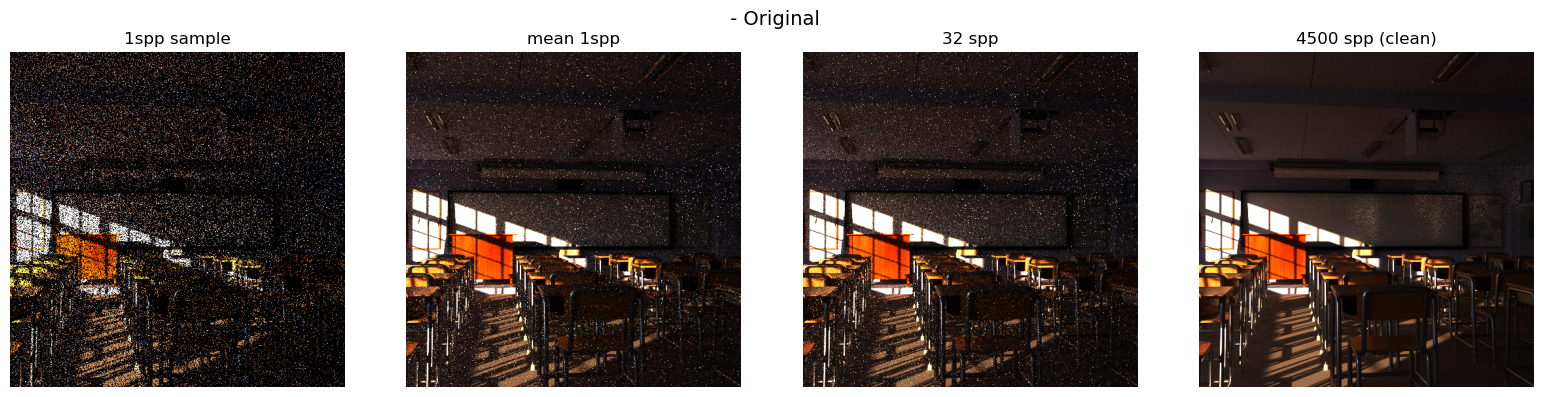


 Box-Cox (λ=0.2) statistics:
Image 1spp sample:
R: min=-4.6845, max=9.3345, mean=-3.4183, std=1.9056
G: min=-4.6845, max=8.6608, mean=-3.5183, std=1.7484
B: min=-4.6845, max=7.7601, mean=-3.6113, std=1.6469
Image mean 1spp:
R: min=-4.6845, max=4.5539, mean=-1.6524, std=0.8554
G: min=-4.6845, max=4.0881, mean=-1.8975, std=0.7700
B: min=-4.6845, max=3.5148, mean=-2.0127, std=0.7285
Image 32 spp:
R: min=-4.6845, max=4.7473, mean=-1.6534, std=0.8565
G: min=-4.6845, max=4.2403, mean=-1.8978, std=0.7708
B: min=-4.6845, max=3.6370, mean=-2.0129, std=0.7289
Image 4500 spp (clean):
R: min=-4.1991, max=4.3654, mean=-1.5188, std=0.7037
G: min=-4.2337, max=3.8794, mean=-1.7811, std=0.6397
B: min=-4.6845, max=3.3095, mean=-1.9039, std=0.6010


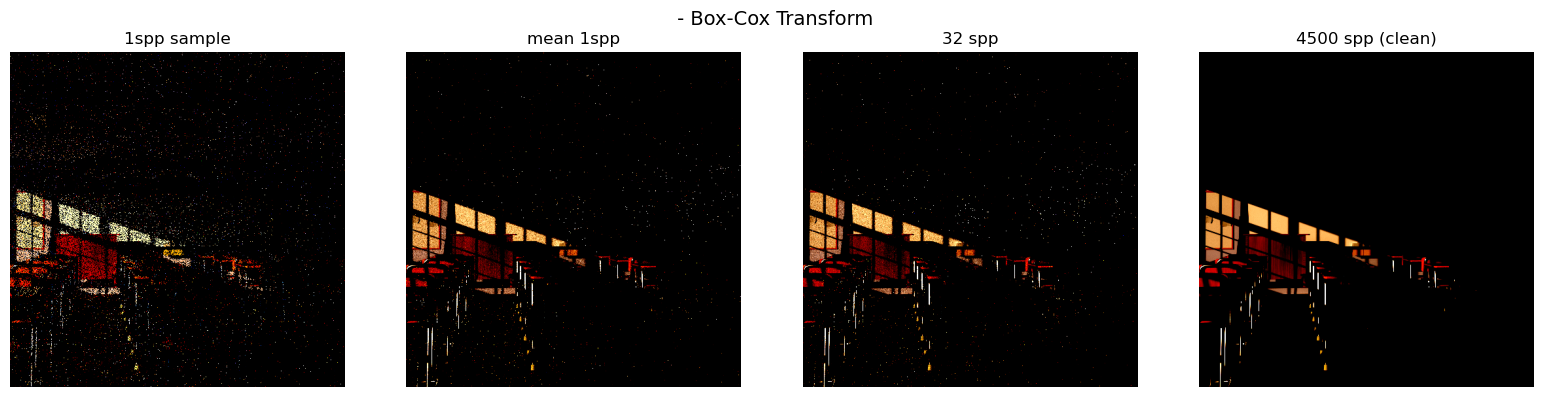


 Standardized Box-Cox statistics:
Image 1spp sample:
R: min=-0.6645, max=6.6924, mean=-0.0000, std=1.0000
G: min=-0.6670, max=6.9657, mean=-0.0000, std=1.0000
B: min=-0.6517, max=6.9048, mean=-0.0000, std=1.0000
Image mean 1spp:
R: min=-3.5447, max=7.2552, mean=-0.0000, std=1.0000
G: min=-3.6195, max=7.7732, mean=-0.0000, std=1.0000
B: min=-3.6679, max=7.5880, mean=0.0000, std=1.0000
Image 32 spp:
R: min=-3.5391, max=7.4732, mean=0.0000, std=1.0000
G: min=-3.6155, max=7.9638, mean=0.0000, std=1.0000
B: min=-3.6655, max=7.7516, mean=-0.0000, std=1.0000
Image 4500 spp (clean):
R: min=-3.8087, max=8.3613, mean=0.0000, std=1.0000
G: min=-3.8342, max=8.8491, mean=-0.0000, std=1.0000
B: min=-4.6268, max=8.6748, mean=0.0000, std=1.0000


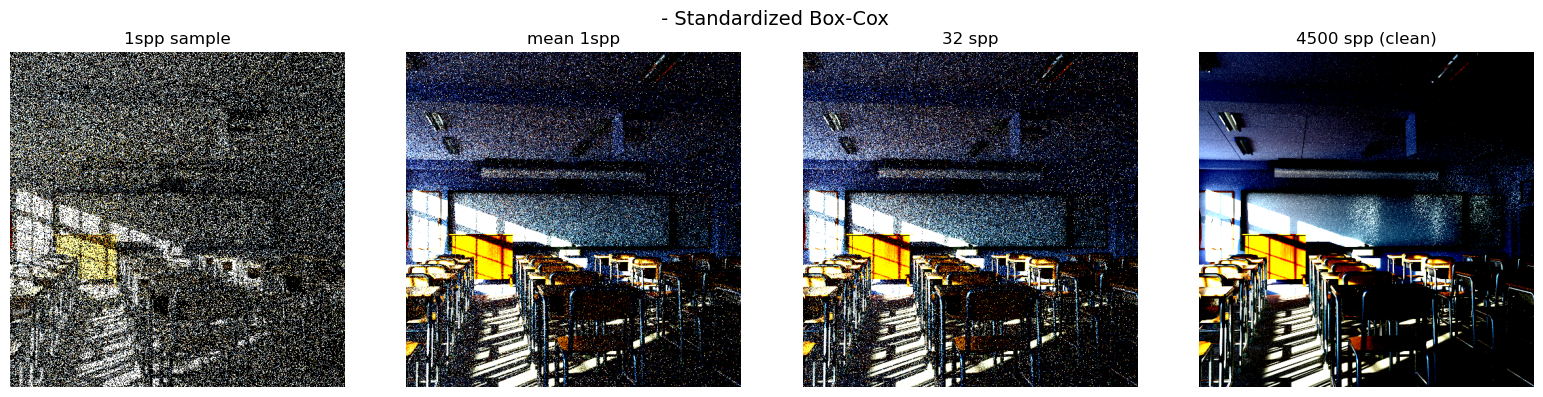


 Recovered Images (Inverse Box-Cox & Unstandardize) statistics:
Image 1spp sample:
R: min=0.0000, max=193.6735, mean=0.2658, std=1.4447
G: min=0.0000, max=152.2388, mean=0.1788, std=1.0256
B: min=0.0000, max=108.2480, mean=0.1399, std=0.7442
Image mean 1spp:
R: min=0.0000, max=25.4712, mean=0.2710, std=0.6673
G: min=0.0000, max=19.8385, mean=0.1823, std=0.4885
B: min=0.0000, max=14.3229, mean=0.1430, std=0.3554
Image 32 spp:
R: min=0.0000, max=28.1558, mean=0.2715, std=0.6768
G: min=0.0000, max=21.5564, mean=0.1827, std=0.4944
B: min=0.0000, max=15.3799, mean=0.1433, std=0.3593
Image 4500 spp (clean):
R: min=0.0001, max=23.0560, mean=0.2712, std=0.6026
G: min=0.0001, max=17.6631, mean=0.1826, std=0.4426
B: min=-0.0000, max=12.6773, mean=0.1432, std=0.3198


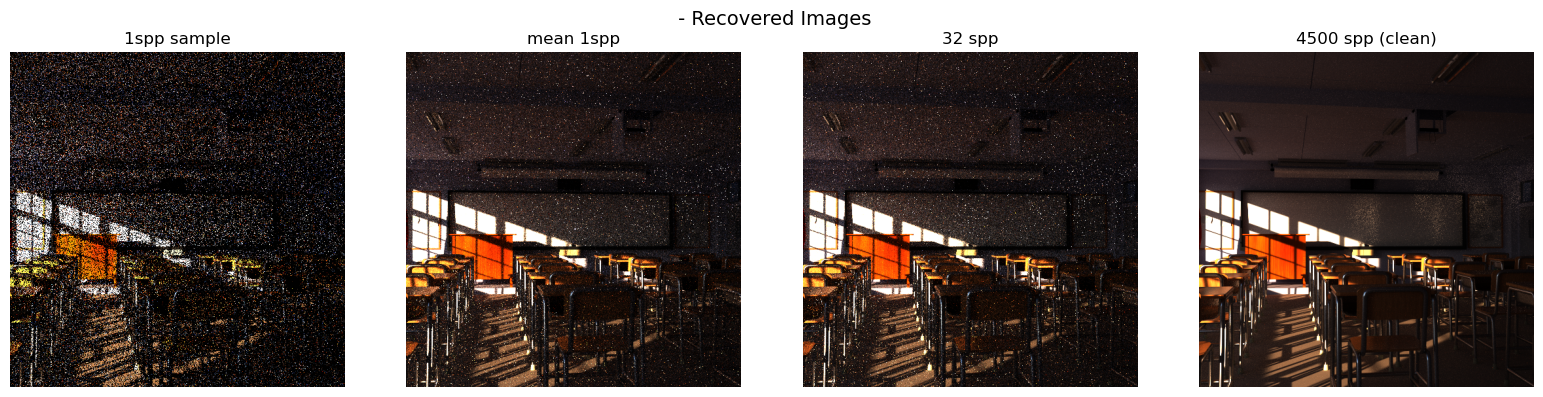

In [ ]:
scene_path = "../output/classroom/"
process_scene_boxcox_std(scene_path)

# Albedo Normalisation

Radiance (RGB) = Albedo * Shading ---> Shading = Radiance (RGB) / Albedo + eps

where: 
- **radiance** (RGB) = amount of light
- **albedo** = true color of a surface/how much light it reflects
- **shading** = how light/shadow fall ona surface

Albedo Normalisation is more consistent across different scenes but reverted image may be darker than the original one.

In [ ]:
import mitsuba as mi
import numpy as np
import matplotlib.pyplot as plt
import os

def compute_channel_stats(img, name="Image"):
    """
    Computes and prints per-channel mean and std for a given image.
    Assumes img shape is (H, W, C)
    """
    print(f"\n{name} Statistics:")
    for i, color in enumerate(['R', 'G', 'B']):
        channel = img[..., i]
        print(f"  {color}: mean={channel.mean():.4f}, std={channel.std():.4f}")

def safe_divide(numerator, denominator, eps=1e-4):
    return numerator / np.clip(denominator, eps, None)

def render_scene_with_albedo(scene_folder, spp=16):
    mi.set_variant("llvm_ad_rgb")

    scene_path = os.path.join(scene_folder, "scene.xml")
    scene = mi.load_file(scene_path)

    # Define AOV integrator that includes albedo
    integrator = mi.load_dict({
        'type': 'aov',
        'aovs': 'aa:albedo',
        'my_image': {
            'type': 'path'
        }
    })

    # Render the full image (RGB + AOVs)
    img_full = mi.render(scene, spp=spp, integrator=integrator)
    img_full = np.array(img_full)

    # The output shape is (H, W, N_channels)
    H, W, C = img_full.shape

    if C < 6:
        raise RuntimeError(f"Expected at least 6 channels (RGB + albedo), got {C}.")

    # Split RGB and albedo
    img_rgb = img_full[..., 0:3]
    img_albedo = img_full[..., 3:6]

    # Clamp to avoid NaNs / divisions by zero
    img_rgb = np.clip(img_rgb, 0, 1)
    img_albedo = np.clip(img_albedo, 1e-4, 1.0)

    # Reconstruct shading: RGB = Albedo * Shading → Shading ≈ RGB / Albedo
    img_shading = safe_divide(img_rgb, img_albedo)
    img_shading = np.clip(img_shading, 0, 1)

    # Recover radiance from shading and albedo
    img_recovered = img_shading * img_albedo
    img_recovered = np.clip(img_recovered, 0, 1)

    # Statistics
    compute_channel_stats(img_rgb, "Rendered Radiance")
    compute_channel_stats(img_albedo, "Albedo")
    compute_channel_stats(img_shading, "Shading (Radiance / Albedo)")
    compute_channel_stats(img_recovered, "Recovered Radiance")

    # PSNR between original and recovered radiance
    psnr = compute_psnr(img_recovered, img_rgb)
    print(f"\nPSNR between original and recovered radiance: {psnr:.2f} dB")

    # Plot
    fig, axes = plt.subplots(1, 4, figsize=(24, 6))
    axes[0].imshow(img_rgb)
    axes[0].set_title("Rendered Radiance (Path)")
    axes[1].imshow(img_albedo)
    axes[1].set_title("AOV: Albedo")
    axes[2].imshow(img_shading)
    axes[2].set_title("Approx. Shading (Radiance / Albedo)")
    axes[3].imshow(img_recovered)
    axes[3].set_title("Recovered Radiance (Shading * Albedo)")

    for ax in axes:
        ax.axis("off")
    plt.tight_layout()
    plt.show()


Rendered Radiance Statistics:
  R: mean=0.3124, std=0.3546
  G: mean=0.2510, std=0.3316
  B: mean=0.1899, std=0.2906

Albedo Statistics:
  R: mean=0.4495, std=0.2828
  G: mean=0.3926, std=0.3158
  B: mean=0.3650, std=0.3358

Shading (Radiance / Albedo) Statistics:
  R: mean=0.4881, std=0.3996
  G: mean=0.4391, std=0.3987
  B: mean=0.3914, std=0.3947

Recovered Radiance Statistics:
  R: mean=0.1996, std=0.2330
  G: mean=0.1394, std=0.2023
  B: mean=0.0939, std=0.1615

PSNR between original and recovered radiance: 11.07 dB


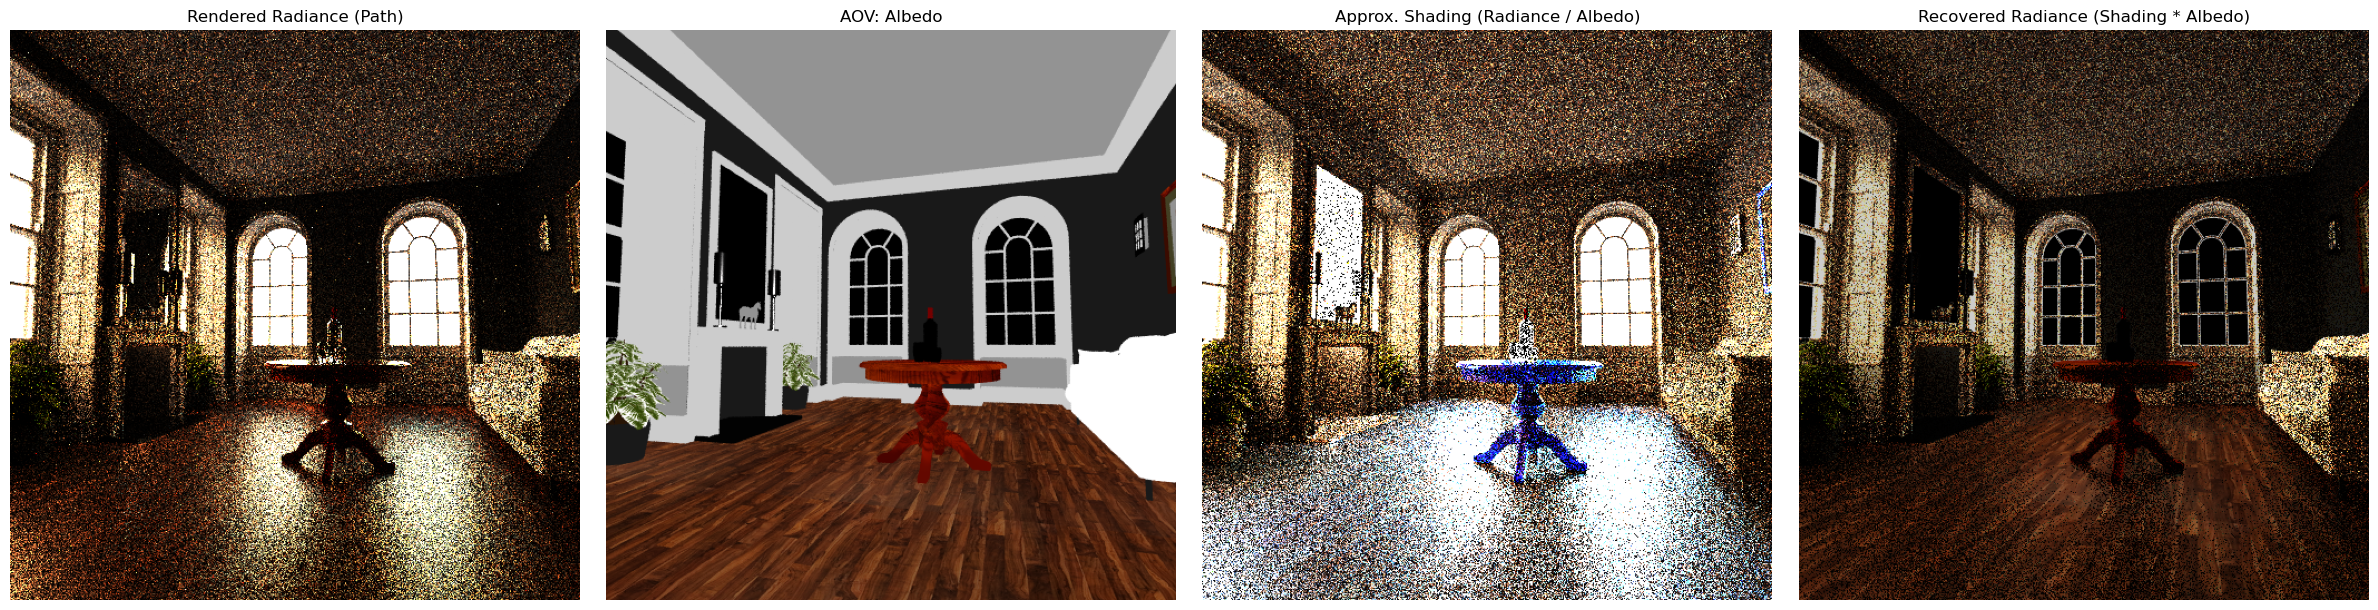

In [ ]:
render_scene_with_albedo("../data/living-room/", spp=16)

# Utils Functions to Save Plots !!!

In [23]:
import os
import numpy as np
import tifffile
import matplotlib.pyplot as plt

def process_3scene(folder_path):
    scene_name = os.path.basename(folder_path)
    files = os.listdir(folder_path)

    path_4500 = next((f for f in files if "spp4500" in f), None)
    path_32   = next((f for f in files if "spp32.tiff" in f and "1x32" not in f), None)
    path_1x32 = next((f for f in files if "spp1x32" in f), None)

    if not all([path_4500, path_32, path_1x32]):
        print(f"Missing files in {scene_name}, skipping...")
        return None

    # Load raw images
    img_clean = tifffile.imread(os.path.join(folder_path, path_4500)).astype(np.float32)
    img_noisy = tifffile.imread(os.path.join(folder_path, path_32)).astype(np.float32)
    img_1spp_stack = tifffile.imread(os.path.join(folder_path, path_1x32)).astype(np.float32)
    img_1spp = img_1spp_stack[0]  # first frame

    # Helper function to save a single image with matplotlib (no axes, no padding)
    def save_image(image, path):
        dpi = 100
        fig_width = image.shape[1] / dpi
        fig_height = image.shape[0] / dpi

        fig = plt.figure(figsize=(fig_width, fig_height), dpi=dpi, frameon=False)
        ax = fig.add_axes([0, 0, 1, 1])
        ax.imshow(np.clip(image, 0, 1))
        ax.axis('off')
        plt.savefig(path, dpi=dpi, pad_inches=0)
        plt.close()

    # Save each separately
    save_image(img_1spp, os.path.join(folder_path, f"{scene_name}_1spp.png"))
    save_image(img_noisy, os.path.join(folder_path, f"{scene_name}_32spp.png"))
    save_image(img_clean, os.path.join(folder_path, f"{scene_name}_4500spp.png"))

    return img_clean, scene_name

def render_4500_grid(parent_dir, save_path="all_4500spp_grid.png"):
    scene_dirs = [os.path.join(parent_dir, d) for d in os.listdir(parent_dir)
                  if os.path.isdir(os.path.join(parent_dir, d))]

    images = []

    for scene_path in scene_dirs:
        files = os.listdir(scene_path)
        path_4500 = next((f for f in files if "spp4500" in f), None)

        if path_4500 is None:
            print(f"Missing 4500spp in {os.path.basename(scene_path)}, skipping...")
            continue

        img = tifffile.imread(os.path.join(scene_path, path_4500)).astype(np.float32)
        images.append(np.clip(img, 0, 1))

    if not images:
        print("No valid 4500spp images found.")
        return

    # Create a single row image grid
    widths = [img.shape[1] for img in images]
    heights = [img.shape[0] for img in images]
    max_height = max(heights)
    total_width = sum(widths)

    # Create canvas
    n_channels = images[0].shape[2] if images[0].ndim == 3 else 1
    canvas = np.ones((max_height, total_width, n_channels), dtype=np.float32)

    x_offset = 0
    for img in images:
        h, w = img.shape[:2]
        canvas[:h, x_offset:x_offset + w] = img
        x_offset += w

    # Save using plt without borders or padding
    dpi = 100
    fig_width = canvas.shape[1] / dpi
    fig_height = canvas.shape[0] / dpi

    fig = plt.figure(figsize=(fig_width, fig_height), dpi=dpi)
    ax = fig.add_axes([0, 0, 1, 1])  # full image without padding
    ax.imshow(canvas)
    ax.axis("off")
    plt.savefig(save_path, dpi=dpi, bbox_inches='tight', pad_inches=0)
    plt.close()


In [24]:
render_4500_grid("../output/")

In [25]:
process_3scene("../output/kitchen/")

(array([[[0.15664387, 0.14341508, 0.13706525],
         [0.14981279, 0.13601662, 0.13098302],
         [0.16781329, 0.15204126, 0.14632002],
         ...,
         [0.19607398, 0.17836662, 0.17150179],
         [0.2360108 , 0.21702479, 0.20709534],
         [0.20141041, 0.18890868, 0.18335894]],
 
        [[0.16248414, 0.14544624, 0.13795532],
         [0.15359685, 0.14090718, 0.13599849],
         [0.15673111, 0.14484921, 0.13954869],
         ...,
         [0.20247275, 0.1869068 , 0.17931554],
         [0.22340359, 0.20690446, 0.19929154],
         [0.22738358, 0.21131591, 0.20402823]],
 
        [[0.16716743, 0.15426302, 0.14896399],
         [0.15322158, 0.13965067, 0.13311593],
         [0.14940621, 0.13428937, 0.12857704],
         ...,
         [0.23882811, 0.21718359, 0.20599529],
         [0.23168644, 0.21662055, 0.20927605],
         [0.22470456, 0.20852822, 0.20152238]],
 
        ...,
 
        [[0.02396722, 0.01225553, 0.00775207],
         [0.02533707, 0.01343494, 0.00861